In [23]:
# Design a 16 ns parametrized control pulse to implement a Hadamard gate in 
# a transmon qubit while suppressing leakage to the |2> level.

# The pulse is parametrized as a Fourier series:

#     Ω_x(t) = 2π·ν_Ref · Σ a(n) · sin((2n-1)·π·t/T)
#     Ω_y(t) = 2π·ν_Ref · Σ b(n) · cos((2n-1)·π·t/T)

# where a(n) and b(n) are the Fourier coefficients to be optimized.

# To enable optimization of the pulse in analytical form, the fields p.uxBasis 
# and p.uyBasis must be provided. They correspond to the harmonics used for 
# Ω_x and Ω_y (sines and cosines in this example). They must be provided as 
# Ncoeff x Nt matrices, each row representing one harmonic evolving in time.

# Estimated script runtime: ~2 seconds.

# AUTHOR:
#     Leo Van Damme / Technical University of Munich, 2025

In [24]:
from Module.parameters import ProblemParameters
from Module.grape import *
import matplotlib.pyplot as plt
from Module.pulse_utils import *
from Module.phys_utils import StateProbability, EigState, GateFidelityMap

In [ ]:
# Problem parameters
p = ProblemParameters(
            QubitFreq = 5e9,    # QubitFreq in Hz
            alpha = -200e6,     # Anharmonicity in Hz
            NLevels = 3,        # Number of energy levels
            dt = 0.1e-9,        # Timestep in s.
            Nt = 160,           # Number of time steps
            CompSpace = [0,1],  # Indices of the computational states
            Target = [[1, 1],   # Target: Hadamard gate
                      [1,-1]]/np.sqrt(2)    
            )

In [26]:
# Define analytical basis fx, fy such that 
#       ux(t) = Σ ax(n)*fx(n,t),
#       uy(t) = Σ ay(n)*fy(n,t)
NCoeffs = 3                                   # Number of coefficients ax and ay
tau = np.linspace(0, 1, p.Nt)                 # Normalized time: shape (Nt,)
fx = np.zeros((NCoeffs,p.Nt))
fy = np.zeros((NCoeffs,p.Nt))
for n in range(NCoeffs):
    fx[n,:] = np.sin((2*n+1)*np.pi*tau)
    fy[n,:] = np.cos((2*n+1)*np.pi*tau)

# Add into the list of parameters
p.Set(uxBasis = fx, uyBasis = fy)

In [27]:
# Initial guess: Random coefficients
ax0 = np.random.randn(NCoeffs)
ay0 = np.random.randn(NCoeffs)

In [28]:
# Optimization options
gopt=Grape(Maxiter=500)

In [29]:
# Optimize the pulse
ax, ay, J = gopt.Optimize(p,ax0, ay0)

Compiling cost function... Done.
########### OPTIMIZATION RESULTS ###########
Cost before optimization: 0.853464373454
Cost after optimization: 0.000000000000
Number of Iterations: 54


In [30]:
# Get the pulse shapes from the coefficients
#       ux(t) = Σ ax(n)*uxBasis(n,t),
#       uy(t) = Σ ay(n)*uyBasis(n,t)
ux = p.TruxBasis @ ax
uy = p.TruyBasis @ ay

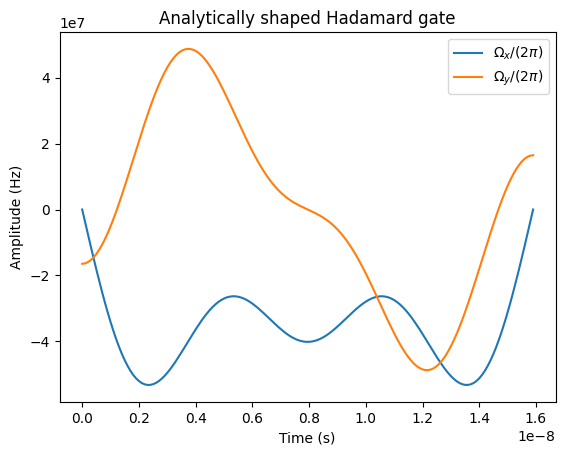

In [31]:
# Display In-phase and quadrature component in Hz
plt.figure()
plt.plot(p.tc, p.nuRef*ux, p.tc, p.nuRef*uy)

# Labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Hz)')
plt.legend([r'$\Omega_x/(2\pi)$', r'$\Omega_y/(2\pi)$'],
            loc='upper right')
plt.title(f"Analytically shaped Hadamard gate")

plt.show()


In [32]:
# Compute transition probabilities

# Probability of the transition |0> → |1>
psi_init = EigState(StateIndice='|0>', NLevels=p.NLevels)
psi_meas = EigState(StateIndice='|1>', NLevels=p.NLevels)
P01= StateProbability(p,ux,uy,InitState=psi_init, MeasState=psi_meas)

# Probability of the transition |0> → |1>
psi_init = EigState(StateIndice='|1>', NLevels=p.NLevels)
psi_meas = EigState(StateIndice='|0>', NLevels=p.NLevels)
P10= StateProbability(p,ux,uy,InitState=psi_init, MeasState=psi_meas)

# Probability of the transition |0> → |2>
psi_init = EigState(StateIndice='|0>', NLevels=p.NLevels)
psi_meas = EigState(StateIndice='|2>', NLevels=p.NLevels)
P02 = StateProbability(p,ux,uy,InitState=psi_init, MeasState=psi_meas)

# Probability of the transition |1> → |2>
psi_init = EigState(StateIndice='|1>', NLevels=p.NLevels)
psi_meas = EigState(StateIndice='|2>', NLevels=p.NLevels)
P12 = StateProbability(p,ux,uy,InitState=psi_init, MeasState=psi_meas)

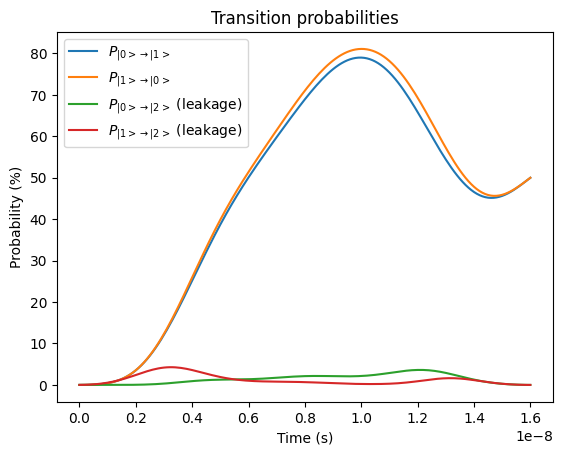

In [33]:
# Display leakage
plt.figure()
plt.plot(p.t,P01*100)
plt.plot(p.t,P10*100)
plt.plot(p.t,P02*100)
plt.plot(p.t,P12*100)
plt.xlabel('Time (s)')
plt.ylabel('Probability (%)')
plt.legend([r'$P_{|0>\rightarrow |1>}$', r'$P_{|1>\rightarrow |0>}$',
            r'$P_{|0>\rightarrow |2>}$ (leakage)', r'$P_{|1>\rightarrow |2>}$ (leakage)'])
plt.title("Transition probabilities")
plt.show()
